# SI 618 - Hypothesis testing (t-test and ANOVA)

Version 2021.02.16.1.CT

Today's class will focus on two common statistical techniques used to investigate
hypotheses about the mean values within samples.  We'll spend most of our time 
focusing on ANOVA, as that seems to be scarier than the more familiar t-test.

We will be using two datasets: a simple one about pizza dough recipes and, during our live session, 
a more complex one drawn from a FiveThirtyEight example about biographical films.

We'll start by importing the usual suspects (including scipy, which we haven't used
much so far):

In [1]:
import numpy as np
import pandas as pd
import scipy

And we'll also import the main packages that we'll be using for our statistical analyses:

In [2]:
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Pizza Dough Recipes

https://dasl.datadescription.com/datafile/activating-baking-yeast/?_sfm_methods=Analysis+of+Variance&_sfm_cases=4+59943

To shorten the time it takes him to
make his favorite pizza, a student designed an experiment to
test the effect of sugar and milk on the activation times for
baking yeast. Specifically, he tested four different recipes and
measured how many seconds it took for the same amount of
dough to rise to the top of a bowl. He randomized the order
of the recipes and replicated each treatment 4 times.

Let's go ahead and read in the data/activating-baking-yeast.txt file into a DataFrame called ```yeast```

In [26]:
yeast = pd.read_csv(
    'https://raw.githubusercontent.com/umsi-data-science/si370/master/data/activating-baking-yeast.txt', sep='\t')

As usual, inspect the DataFrame so we know what we're dealing with:

In [27]:
yeast.head()

,Activation Times,Recipe
0,575,A
1,395,A
2,280,B
3,120,B
4,720,C


In [28]:
yeast.columns

Index(['Activation Times', 'Recipe '], dtype='object')

Those column names aren't nice to work with, so let's go ahead and rename them
to ```activation``` and ```recipe```

In [29]:
to_be_renamed = {"Activation Times": "activation", "Recipe ": "recipe"}
yeast = yeast.rename(columns=to_be_renamed)

In [30]:
yeast.head()

,activation,recipe
0,575,A
1,395,A
2,280,B
3,120,B
4,720,C


Let's start by visually examining our data:

In [31]:
import seaborn as sns

### Q2: Create a boxplot the looks like the following:
![](resources/pizza-boxplot.png)

<AxesSubplot:xlabel='recipe', ylabel='activation'>

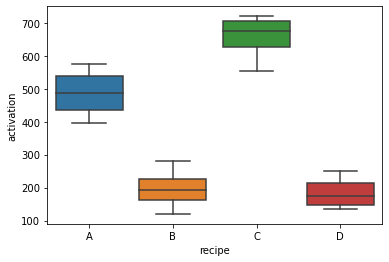

In [32]:
sns.boxplot(x="recipe", y="activation", data=yeast)

## Let's do an ANOVA!
We want to know if the above differences are statistically "real".  In other words, 
we want to know if the activation times vary according to the recipes.

We use statsmodels.forumula.api to create the model in a "readable" way.  For example, 
```activation ~ recipe``` would do that for us.  So we're going to create a model,
fit it to the data, and examine it.  We'll talk about the "Type 2" bit in class.

In [33]:
# linear model-ols
# anova table
yeast_lm = ols('activation ~ recipe', data=yeast).fit()
table = sm.stats.anova_lm(yeast_lm, typ=2)  # Type 2 ANOVA DataFrame
table

,sum_sq,df,F,PR(>F)
recipe,638967.6875,3.0,44.739175,8.639741e-07
Residual,57128.2500,12.0,NaN,NaN


### What does that tell us?

Where do all those numbers come from?  Let's walk through an ANOVA by hand:
(this material based on https://jooskorstanje.com/1_Way_ANOVA_Pizza_Delivery.html)

In [34]:
yeast.head()

,activation,recipe
0,575,A
1,395,A
2,280,B
3,120,B
4,720,C


In [35]:
yeast.groupby('recipe').mean()

,activation
recipe,
A,486.25
B,196.25
C,656.00
D,183.75


In [36]:
# compute overall mean

overall_mean = yeast['activation'].mean()
overall_mean

380.5625

In [37]:
# compute sum of squares total
yeast['overall_mean'] = overall_mean
ss_total = sum((yeast['activation'] - yeast['overall_mean'])**2)
ss_total

696095.9375

In [38]:
# compute group means
group_means = yeast.groupby('recipe').mean()
group_means = group_means.rename(
    columns={'activation': 'group_mean'})  # rename
group_means

,group_mean,overall_mean
recipe,,
A,486.25,380.5625
B,196.25,380.5625
C,656.00,380.5625
D,183.75,380.5625


In [39]:
# add group means and overall mean to the original data frame
yeast = yeast.merge(group_means['group_mean'],
                    left_on='recipe', right_index=True, indicator=True)
# remian right df's index, can merge on index
yeast

,activation,recipe,overall_mean,group_mean,_merge
0,575,A,380.5625,486.25,both
1,395,A,380.5625,486.25,both
8,525,A,380.5625,486.25,both
9,450,A,380.5625,486.25,both
2,280,B,380.5625,196.25,both
3,120,B,380.5625,196.25,both
10,175,B,380.5625,196.25,both
11,210,B,380.5625,196.25,both
4,720,C,380.5625,656.00,both
5,554,C,380.5625,656.00,both


In [41]:
# compute sum of squares residual
ss_residual = sum((yeast['activation'] - yeast['group_mean'])**2)
ss_residual

57128.25

In [42]:
# compute Sum of Squares Model/explained
ss_explained = sum((yeast['overall_mean'] - yeast['group_mean'])**2)
ss_explained

638967.6875

In [44]:
# compute Mean Square Residual
n_groups = len(set(yeast['recipe']))
n_obs = yeast.shape[0]
df_residual = n_obs - n_groups
ms_residual = ss_residual / df_residual
ms_residual

4760.6875

In [45]:
# compute Mean Square Explained
df_explained = n_groups - 1
ms_explained = ss_explained / df_explained
ms_explained

212989.22916666666

In [46]:
# compute F-Value
f = ms_explained / ms_residual
f

44.739174576501114

In [47]:
# compute p-value
import scipy.stats
p_value = 1 - scipy.stats.f.cdf(f, df_explained, df_residual)
p_value

8.63974071951823e-07

In [48]:
# (from our ANOVA way above)
table

,sum_sq,df,F,PR(>F)
recipe,638967.6875,3.0,44.739175,8.639741e-07
Residual,57128.2500,12.0,NaN,NaN


In [51]:
# want to examine whether the activition time varies becuase of the receipes
# PR(>F)=8.639741e-07 tell us, yes there is significant difference between some receipes
#   i.e. the likelihood of getting F-statistics(44.739175)（这个样本关系是accidently、bychance发生的，才得到这个大f） is 8.639741e-07 (really samll)
#   so there is effect of receipes on activition time
# df = degree of freedom = number of recipe -1 = N-1
# 
#

# p值越大，我们越不能认为样本中变量的关联是总体中各变量关联的可靠指标。
# p值是将 观察结果认为有效即具有总体代表性 （样本规律推至总体）的犯错概率。
# 所以p值小，我们才能推论
# p很小，很小的概率 of 犯错，很小概率说总体之间变量有关 是错的，所以可以说 变量之间有关系！

## Tukey's Honestly Significant Differences (HSD)

Ok, so we know there are significant differences between the different recipes, but
which one(s) are different from other ones?  To answer that, we can use Tukey's HSD (Honestly Sigificant Differences):

In [55]:
# anova: know whether there are significant differences between the different recipes
# Tukey's HSD: which one(s) are different from other ones

In [52]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [53]:
res2 = pairwise_tukeyhsd(yeast['activation'], yeast['recipe'])
res2.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,-290.0,0.001,-434.8661,-145.1339,True
A,C,169.75,0.0205,24.8839,314.6161,True
A,D,-302.5,0.001,-447.3661,-157.6339,True
B,C,459.75,0.001,314.8839,604.6161,True
B,D,-12.5,0.9,-157.3661,132.3661,False
C,D,-472.25,0.001,-617.1161,-327.3839,True


In [54]:
# H0: no differnce between 2 groups
# reject: True == 2 groups has significent differece